# Using unlabelled, unfractionated datasets obtained from QExact and VOrbi instruments
* Datasets were searched against H_sapiens_Uniprot_SPROT_2017-04-12, Tryp_Pig_Bov sequence files using MSGFPlus
* Combined results with MASIC results (q <= 0.01) to get quantitation data

In [ ]:
import Classification_Utils as cu
import MaxQuant_Postprocessing_Functions as mq
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import time

## Load and combine data from all tissues

In [ ]:
df = pd.read_csv('FullPeptideQuant.txt', sep='\t', index_col='Peptide')
print(df.shape)

## Map each column to a corresponding label

In [ ]:
tissues = ['Blood_Plasma', 'Blood_Serum', 'CSF', 'Liver', 'Monocyte', 'Ovary', 'Pancreas', 'Substantia_Nigra', 'Temporal_Lobe']
 
tissues_to_columns = cu.map_tissues_to_columns(df, tissues)

In [ ]:
column_names = df.columns.values.tolist()
labels = cu.get_labels(column_names, tissues_to_columns)

In [36]:
df.head()

,Blood_Plasma_CPTAC_TrypDige_undepleted_normal_19Apr13_Methow_13-02-13,Blood_Plasma_Darpa_2_human_02_23Jan17_Arwem_16-10-25,Blood_Plasma_OMICS_EBV_HP_UW001_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW002_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW003_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW004_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW005_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW006_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW007_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW008_8Apr16_Arwen_16-01-03,...,Temporal_Lobe_Alz_FX1P159_Guan_1_26Jul10_Andromeda_10-06-28,Temporal_Lobe_Alz_FX1P159_Guan_2_26Jul10_Andromeda_10-06-29,Temporal_Lobe_Alz_FX1P159_Guan_3_26Jul10_Andromeda_10-06-28,Temporal_Lobe_Alz_FX1P159_Guan_Typx2_1_26Jul10_Andromeda_10-06-29,Temporal_Lobe_Alz_FX1P159_Guan_Typx2_2_26Jul10_Andromeda_10-06-28,Temporal_Lobe_Alz_FX1P159_Guan_Typx2_3_26Jul10_Andromeda_10-06-29,Temporal_Lobe_Alz_FX2P57_IMAC_153_9May11_Hawk_11-04-02p,Temporal_Lobe_Alz_FX2P57_IMAC_161_20Apr11_Hawk_10-12-03p,Temporal_Lobe_Alz_FX2P57_IMAC_187_26Apr11_Hawk_10-12-03p,Temporal_Lobe_Alz_FX2P57_IMAC_212_11May11_Hawk_11-04-02p
Peptide,,,,,,,,,,,,,,,,,,,,,
\n-.DIQM*TQSPSTLSASVGDR.V,26.731951,22.187643,3.022208,29.328345,29.916272,3.022208,27.586706,30.458361,29.004130,31.023004,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
\n-.DIQM*TQSPSTLSASVGDRVTITCR.A,3.022208,3.022208,3.022208,30.633308,30.815586,3.022208,29.483431,32.564995,30.319263,32.368436,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
\n-.DIQMTQSPSTLSASVGDR.V,26.387537,28.015792,3.022208,3.022208,31.403752,3.022208,27.695976,29.779972,29.747784,30.255299,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
\n-.DIQMTQSPSTLSASVGDRVTITCR.A,3.022208,3.022208,3.022208,3.022208,32.585511,3.022208,3.022208,30.845879,30.983525,27.526416,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
\n-.EVQLVETGGGLIQPGGSLR.L,24.546220,3.022208,3.022208,3.022208,26.732727,3.022208,28.163126,23.836245,3.022208,28.436388,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208


## Make train-test split

In [37]:
train_df, test_df, train_labels, test_labels = train_test_split(
    df.T, labels, 
    test_size=0.30,    # 30% of the data held out in test set
    random_state=0,    # Setting random_state ensures the same train/test split occurs each time this is run
    stratify=labels)   # Maintain ratio of tissues represented in each set

### Optional step to transform data

percentile_to_keep = 100
train_df = train_df.T
train_df = cu.keep_percentile_features(train_df, train_labels, percentile_to_keep)
features_to_keep = train_df.index.values.tolist()

train_df = train_df.T
print(train_df.shape)

## Train various classifiers, using cross-validation to produce an accuracy score

In [38]:
NUM_SPLITS = 100 # number of train/test splits in cross validation

### KNN

In [39]:
knn = cu.knn_model_crossval(train_df, train_labels, NUM_SPLITS)

accuracy: 0.89 (+/- 0.09)


### Logistic Regression

In [40]:
lr = cu.logistic_regression_model_crossval(train_df, train_labels, NUM_SPLITS)

accuracy: 0.99 (+/- 0.03)


### Naive Bayes
* Gaussian
* Multinomial

In [41]:
gnb = cu.bayes_gaussian_model_crossval(train_df, train_labels, NUM_SPLITS)

accuracy: 0.92 (+/- 0.07)


In [42]:
mnb = cu.bayes_multinomial_model_crossval(train_df, train_labels, NUM_SPLITS)

accuracy: 0.85 (+/- 0.09)


### SVC variations

In [43]:
svc_models = cu.SVC_models_crossval(train_df, train_labels, NUM_SPLITS)

accuracy: 0.98 (+/- 0.03)
accuracy: 0.99 (+/- 0.03)
accuracy: 0.11 (+/- 0.00)
accuracy: 0.92 (+/- 0.07)


### Aggregations
* Random Forest
* Gradient Boosting

In [44]:
rf = cu.randomforest_model_crossval(train_df, train_labels, NUM_SPLITS)

accuracy: 0.96 (+/- 0.06)


In [45]:
gbc = cu.gradient_boosting_crossval(train_df, train_labels, NUM_SPLITS)

accuracy: 0.94 (+/- 0.06)


## Classify Training Set

### Use models from notebook to predict new data

In [46]:
lr_pred = lr.predict(test_df)
lr_result = lr.score(test_df, test_labels)

mnb_pred = mnb.predict(test_df)
mnb_result = mnb.score(test_df, test_labels)

rf_pred = rf.predict(test_df)
rf_result = rf.score(test_df, test_labels)

svc_pred = svc_models[0].predict(test_df)
svc_result = svc_models[0].score(test_df, test_labels)

gbc_pred = gbc.predict(test_df)
gbc_result = gbc.score(test_df, test_labels)

gnb_pred = gnb.predict(test_df)
gnb_result = gnb.score(test_df, test_labels)

knn_pred = knn.predict(test_df)
knn_result = knn.score(test_df, test_labels)

In [47]:
print(lr_result)
print(mnb_result)
print(rf_result)
print(svc_result)

print(gbc_result)
print(gnb_result)
print(knn_result)

1.0
0.828947368421
1.0
1.0
1.0
0.960526315789
0.947368421053


##  Confusion matrices of model's predictions on new data

Confusion matrix, without normalization
[[9 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 3 6]]
Normalized confusion matrix
[[ 1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.33  0.67]]


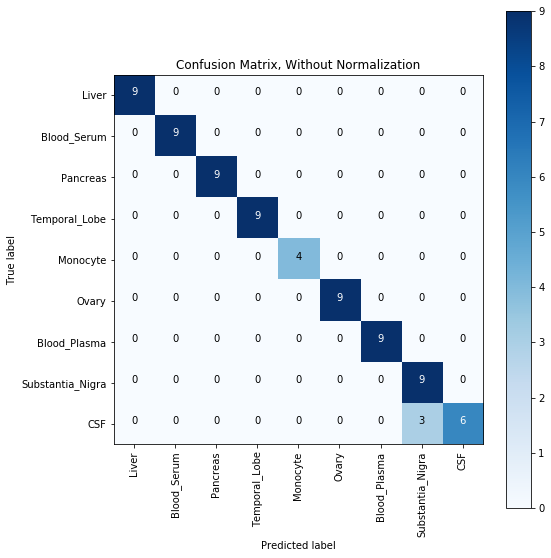

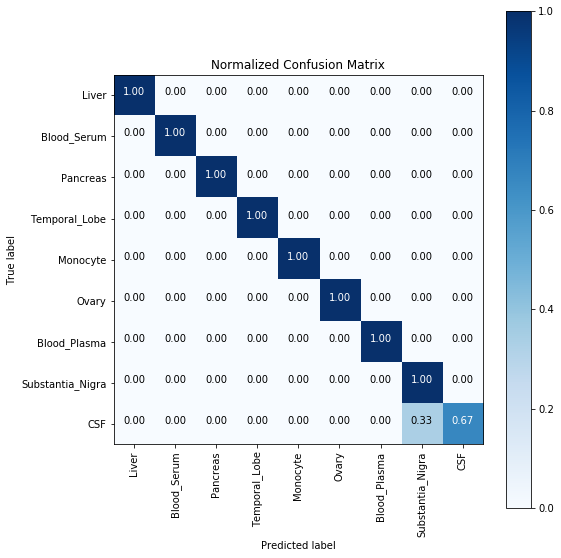

In [48]:
cm_labels = list(set(gnb_pred.tolist() + test_labels))

cu.show_confusion_matrices(test_labels, gnb_pred, cm_labels)